<a href="https://colab.research.google.com/github/pythonuzgit/elmurodov/blob/master/Knowledge%20Graph/Knowledge_Graph_Learning_with_Spacy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import numpy as np # linear algebra
import pandas as pd

import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import spacy
from spacy.lang.en import English
import networkx as nx
import matplotlib.pyplot as plt

from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

Importing the Data

In [23]:
bbc_text = pd.read_csv("/content/bbc_text_cls.csv")

In [24]:
bbc_text.head()

,text,labels
0,"Ad sales boost Time Warner profit\n\nQuarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier.\n\nThe firm, which is n...",business
1,Dollar gains on Greenspan speech\n\nThe dollar has hit its highest level against the euro in almost three months after the Federal Reserve head said the US trade deficit is set to stabilise.\n\nAn...,business
2,Yukos unit buyer faces loan claim\n\nThe owners of embattled Russian oil giant Yukos are to ask the buyer of its former production unit to pay back a $900m (£479m) loan.\n\nState-owned Rosneft bou...,business
3,"High fuel prices hit BA's profits\n\nBritish Airways has blamed high fuel prices for a 40% drop in profits.\n\nReporting its results for the three months to 31 December 2004, the airline made a pr...",business
4,Pernod takeover talk lifts Domecq\n\nShares in UK drinks and food firm Allied Domecq have risen on speculation that it could be the target of a takeover by France's Pernod Ricard.\n\nReports in th...,business


In [25]:
bbc_text.drop(columns = ["labels"], inplace =True)

In [26]:
bbc_text['text'].head()

0    Ad sales boost Time Warner profit\n\nQuarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier.\n\nThe firm, which is n...
1    Dollar gains on Greenspan speech\n\nThe dollar has hit its highest level against the euro in almost three months after the Federal Reserve head said the US trade deficit is set to stabilise.\n\nAn...
2    Yukos unit buyer faces loan claim\n\nThe owners of embattled Russian oil giant Yukos are to ask the buyer of its former production unit to pay back a $900m (£479m) loan.\n\nState-owned Rosneft bou...
3    High fuel prices hit BA's profits\n\nBritish Airways has blamed high fuel prices for a 40% drop in profits.\n\nReporting its results for the three months to 31 December 2004, the airline made a pr...
4    Pernod takeover talk lifts Domecq\n\nShares in UK drinks and food firm Allied Domecq have risen on speculation that it could be the target of a takeover by France's Pernod Ric

In [27]:
bbc_text.head()

,text
0,"Ad sales boost Time Warner profit\n\nQuarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier.\n\nThe firm, which is n..."
1,Dollar gains on Greenspan speech\n\nThe dollar has hit its highest level against the euro in almost three months after the Federal Reserve head said the US trade deficit is set to stabilise.\n\nAn...
2,Yukos unit buyer faces loan claim\n\nThe owners of embattled Russian oil giant Yukos are to ask the buyer of its former production unit to pay back a $900m (£479m) loan.\n\nState-owned Rosneft bou...
3,"High fuel prices hit BA's profits\n\nBritish Airways has blamed high fuel prices for a 40% drop in profits.\n\nReporting its results for the three months to 31 December 2004, the airline made a pr..."
4,Pernod takeover talk lifts Domecq\n\nShares in UK drinks and food firm Allied Domecq have risen on speculation that it could be the target of a takeover by France's Pernod Ricard.\n\nReports in th...


To build a knowledge graph, the most important things are the nodes and the edges between them

In [28]:
def get_entities(sent):
  #chunk1
  ent1 = ''
  ent2 = ''

  prv_tok_dep = ''
  prv_tok_text = ''

  prefix = ''
  modifier = ''

  for tok in nlp(sent):
    if tok.dep_ != "punct":
      if tok.dep_ == 'compound':
        prefix = tok.text
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " " + tok.text

      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text 

        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " " + tok.text 

       ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier + " " + prefix + " " + tok.text

        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""


      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier + " " + prefix + " " + tok.text  



      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text 


  return [ent1.strip(), ent2.strip()]      
     

Tokenization and sentence segmentation

In [29]:
bbc_text[32:36]

,text
32,"Rich grab half Colombia poor fund\n\nHalf of the money put aside by the Colombian government to help the country's poor is benefiting people who do not need it, a study has found.\n\nA total of 24..."
33,"Rover deal 'may cost 2,000 jobs'\n\nSome 2,000 jobs at MG Rover's Midlands plant may be cut if investment in the firm by a Chinese car maker goes ahead, the Financial Times has reported.\n\nShangh..."
34,Ad firm WPP's profits surge 15%\n\nUK advertising giant WPP has posted larger-than-expected annual profits and predicted that it will outperform the market in 2005.\n\nPre-tax profits rose 15% fro...
35,US gives foreign firms extra time\n\nForeign firms have been given an extra year to meet tough new corporate governance regulations imposed by the US stock market watchdog.\n\nThe Securities and E...


Use this function to extract these entity pairs for all the texts

In [30]:
entity_pairs = []

for i in tqdm(bbc_text['text']):
  entity_pairs.append(get_entities(i))

entity_pairs[0:5]

100%|██████████| 2225/2225 [02:51<00:00, 12.95it/s]


[['advertising It', 'now AOL stake'],
 ['deficit', 'trillion  dollars'],
 ['downfall', 'political founder Mikhail sale'],
 ['flat  shares', '274.5  pence'],
 ['1.8bn Seagram Allied', 'fast food chains']]

Relation/Predicate Extraction

In [32]:
def get_relation(sent):

    doc = nlp(sent)

    # Matcher class object 
    matcher = Matcher(nlp.vocab)

    #define the pattern 
    pattern = [{'DEP':'ROOT'},
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

    matcher.add("matching_1", [pattern]) 

    matches = matcher(doc)
    k = len(matches) - 1

    span = doc[matches[k][1]:matches[k][2]] 

    return(span.text)
     


Relations from all the BBC_text sentences

In [33]:
relations = [get_relation(i) for i in tqdm(bbc_text['text'])]

100%|██████████| 2225/2225 [02:35<00:00, 14.33it/s]


In [34]:
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [35]:
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

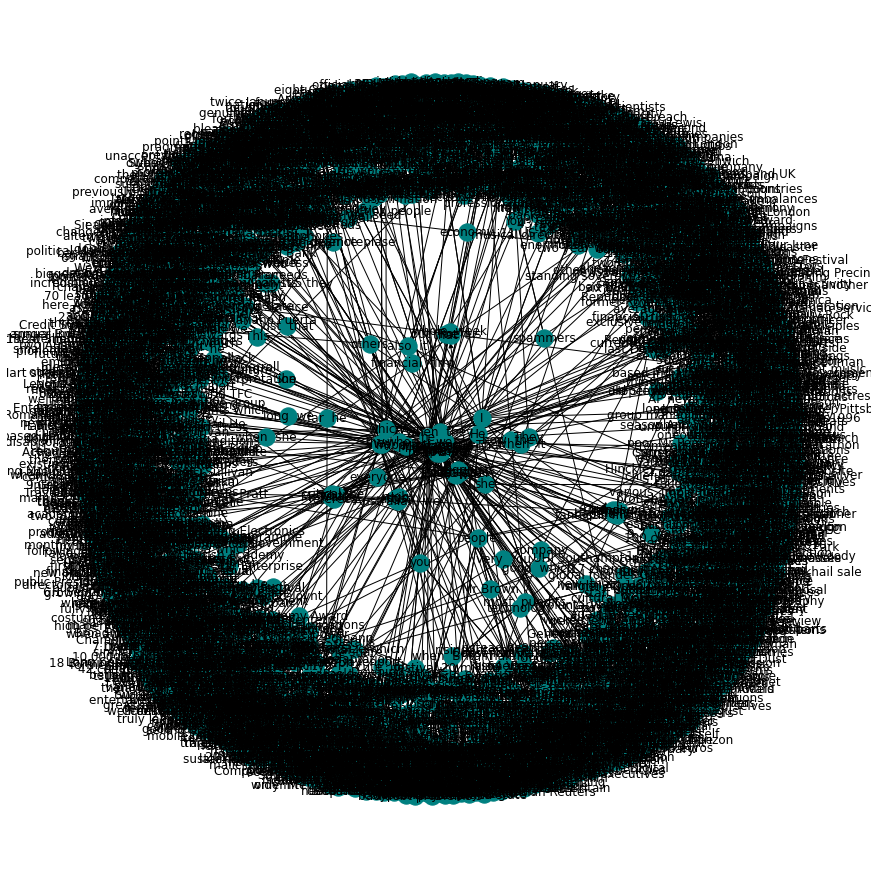

In [36]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='teal', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [43]:
bbc_text[30:40]

,text
30,"Irish markets reach all-time high\n\nIrish shares have risen to a record high, with investors persuaded to buy into the market by low inflation and strong growth forecasts.\n\nThe ISEQ index of le..."
31,"Japanese banking battle at an end\n\nJapan's Sumitomo Mitsui Financial has withdrawn its takeover offer for rival bank UFJ Holdings, enabling the latter to merge with Mitsubishi Tokyo.\n\nSumitomo..."
32,"Rich grab half Colombia poor fund\n\nHalf of the money put aside by the Colombian government to help the country's poor is benefiting people who do not need it, a study has found.\n\nA total of 24..."
33,"Rover deal 'may cost 2,000 jobs'\n\nSome 2,000 jobs at MG Rover's Midlands plant may be cut if investment in the firm by a Chinese car maker goes ahead, the Financial Times has reported.\n\nShangh..."
34,Ad firm WPP's profits surge 15%\n\nUK advertising giant WPP has posted larger-than-expected annual profits and predicted that it will outperform the market in 2005.\n\nPre-tax profits rose 15% fro...
35,US gives foreign firms extra time\n\nForeign firms have been given an extra year to meet tough new corporate governance regulations imposed by the US stock market watchdog.\n\nThe Securities and E...
36,Japanese mogul arrested for fraud\n\nOne of Japan's best-known businessmen was arrested on Thursday on charges of falsifying shareholder information and selling shares based on the false data.\n\n...
37,Deutsche Telekom sees mobile gain\n\nGerman telecoms firm Deutsche Telekom saw strong fourth quarter profits on the back of upbeat US mobile earnings and better-than-expected asset sales.\n\nNet p...
38,"Chinese wine tempts Italy's Illva\n\nItaly's Illva Saronno has agreed to buy 33% of Changyu, the largest wine maker in China.\n\nChangyu said in a statement to the Shenzhen stock exchange that Ill..."
39,Umbro profits lifted by Euro 2004\n\nUK sportswear firm Umbro has posted a 222% rise in annual profit after sales of replica England football kits were boosted by the Euro 2004 tournament.\n\nPre-...


Knowledge Graph for "edge" cloumn values(edge=relations)

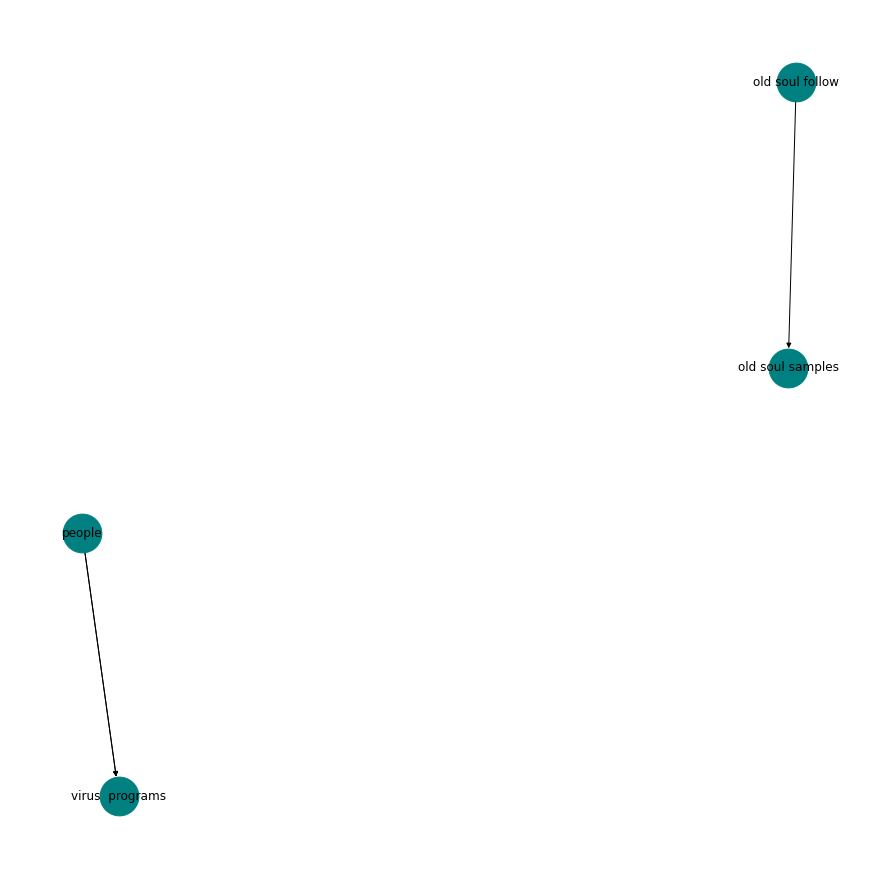

In [44]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="released"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='teal', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

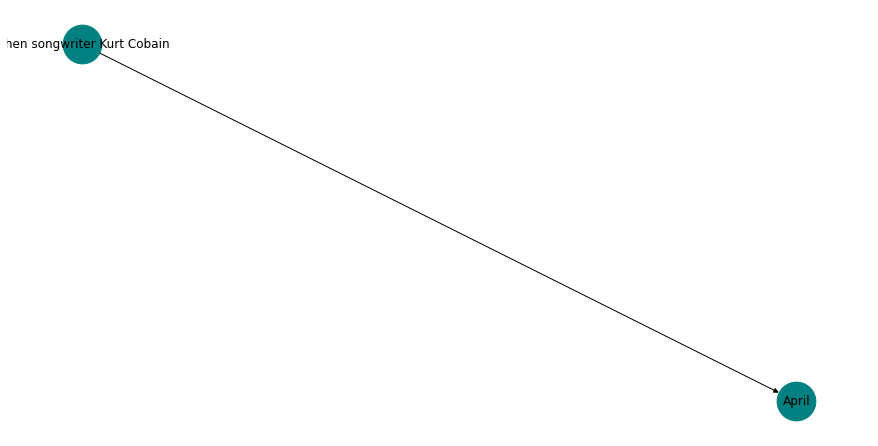

In [45]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="ended"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,6))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='teal', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [52]:
bbc_text[75:80]

,text
75,"Palestinian economy in decline\n\nDespite a short-lived increase in Palestinian jobs in 2003, the economy is performing well below its potential, said a World Bank report.\n\nUnemployment stood at..."
76,"China had role in Yukos split-up\n\nChina lent Russia $6bn (£3.2bn) to help the Russian government renationalise the key Yuganskneftegas unit of oil group Yukos, it has been revealed.\n\nThe Kreml..."
77,Deadline nears for Fiat-GM deal\n\nFiat and General Motors (GM) have until midnight on 1 February to settle a disagreement over a potential takeover.\n\nThe deadline marks the point at which Fiat ...
78,"ID theft surge hits US consumers\n\nAlmost a quarter of a million US consumers complained of being targeted for identity theft in 2004, official figures suggest.\n\nThe Federal Trade Commission sa..."
79,"Argentina, Venezuela in oil deal\n\nArgentina and Venezuela have extended a food-for-oil deal, which helped the former to overcome a severe energy crisis last year.\n\nArgentine President Nestor K..."


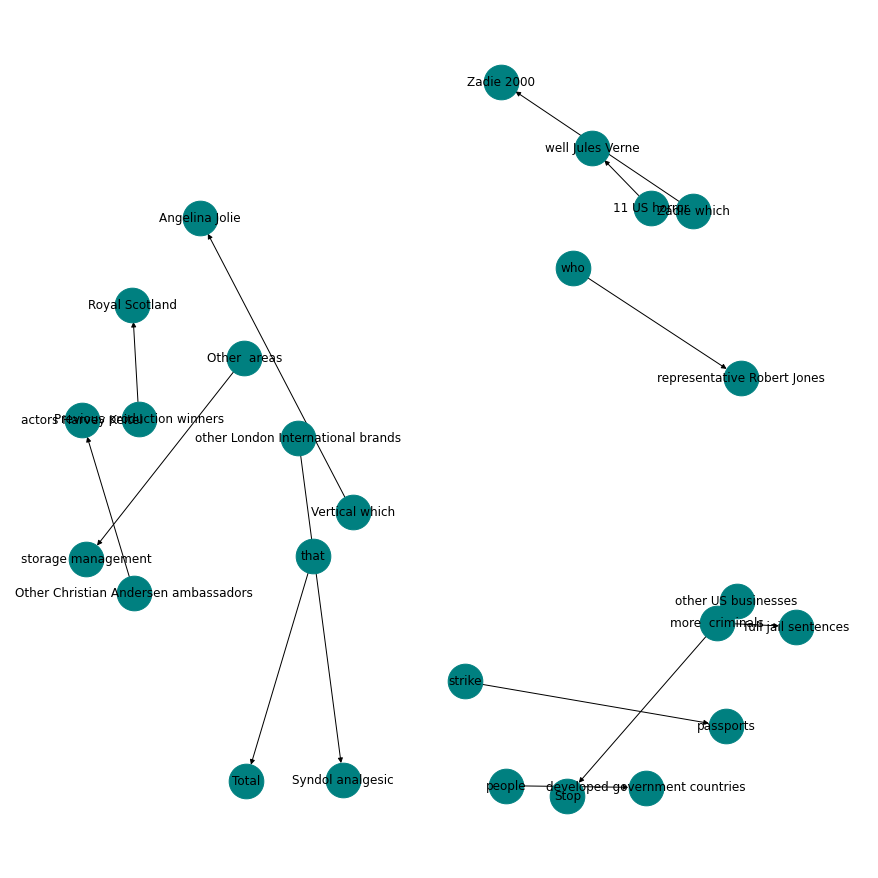

In [53]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="include"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.8)
nx.draw(G, with_labels=True, node_color='teal', node_size=1200, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()